In [11]:
from shapely.geometry import Polygon
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision.io import read_image
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from dataset3_final import CustomDataset
import numpy as np
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import v2 as T
import albumentations as A
from albumentations.pytorch import ToTensorV2
from shapely.ops import unary_union
import json

def get_transform(train):
    if train:
        # Define transformations for training
        return A.Compose([
            A.OneOf([
                A.RandomCrop(width=512, height=512),
                A.LongestMaxSize(max_size=1024)
                ], p=0.5), 
            # Add more transformations as needed
            ToTensorV2() # Converts the image and mask to tensor
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
    else:
        # Define transformations for testing (minimal in this example)
        return A.Compose([
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

annotation_file = 'cropped_fixed_exp50_annotations_no_negatives_final.csv' # CSV PYTORCH ANNOATATION FILE
image_dir = '/home/rohit/AIXI/model0_6/data/test' # IMAGE DIRECTORY FOR TEST DATASET
CSV_output_path = 'solid_fractions.csv' # OUTPUT CSV FILE FOR SOLID FRACTIONS
parent_folder_img = 'binned_images' # PARENT FOLDER FOR BINNED IMAGES
parent_folder_anno = 'binned_images_test1' # PARENT FOLDER FOR BINNED ANNOTATIONS
original_annotation_file = 'fixed_final_coco_annotations_test_set_8_5_24.json'  # ORIGINAL COCO ANNOTATION FILE TO BE SPLIT
master_annotations_folder = 'binned_annotations'  # PARENT FOLDER FOR BINNED ANNOTATIONS
dataset = CustomDataset(annotation_file, image_dir, get_transform(train=False))


############################################################################################################
# step 1 - take image folder and annotation file and populate dataframe with image name and solid fraction
############################################################################################################


# Function to calculate the union area of bounding boxes for a single image
def calculate_union_area(boxes):
    """Calculate the union area of bounding boxes."""
    if len(boxes) == 0:
        return 0
    # Create a list of Polygon objects from the bounding boxes
    polygons = [Polygon([(box[0], box[1]), (box[2], box[1]), (box[2], box[3]), (box[0], box[3])]) for box in boxes]
    # Use unary_union to correctly handle the union of multiple polygons
    union_polygon = unary_union(polygons)
    return union_polygon.area

solid_fractions = []

for i in range(len(dataset)):
    _, target = dataset[i]
    boxes = target['boxes'].numpy()  # Convert boxes to NumPy array for processing
    total_union_area = calculate_union_area(boxes)
    
    # Assuming the dimensions of the images are known and uniform across your dataset
    image_area = target['img_area']  # Update with actual image dimensions
    solid_fraction = total_union_area / image_area
    
    solid_fractions.append({
        'filename': dataset.images[i],  # Accessing filename from dataset
        'solid_fraction': solid_fraction
    })

df = pd.DataFrame(solid_fractions)

df.to_csv(CSV_output_path, index=False)

print("solid fractions calculated and saved to solid_fractions.csv")


############################################################################################################
# step 2 - move images to respective folders based on solid fraction
############################################################################################################


df = pd.read_csv(CSV_output_path)

# Define the bin edges
bins = [i / 100 for i in range(0, 105, 5)]

# Categorize solid fraction values into bins
df['bin'] = pd.cut(df['solid_fraction'], bins=bins, include_lowest=True, right=False)

# Group the dataframe by bin and collect filenames
binned_filenames = df.groupby('bin')['filename'].apply(list).to_dict()

current_directory = os.getcwd()

parent_directory_img = os.path.join(current_directory, parent_folder_img)

# Create the parent directory if it does not exist
if not os.path.exists(parent_directory_img):
    os.makedirs(parent_directory_img)

# Create a directory for each bin and copy the corresponding files
for bin_interval, filenames in binned_filenames.items():
    # Create a directory name based on the bin interval
    dir_name = f'{bin_interval.left * 100:.0f}_{bin_interval.right * 100:.0f}_percent_solid_fraction'
    bin_dir = os.path.join(parent_directory_img, dir_name)
    
    # Create the directory if it does not exist
    if not os.path.exists(bin_dir):
        os.makedirs(bin_dir)
    
    # Copy files to the newly created directory
    for filename in filenames:
        # Define the source and destination paths
        src_path = os.path.join(image_dir, filename)  # Update with actual image directory path
        dest_path = os.path.join(bin_dir, filename)
        
        # Copy the file to the destination directory
        shutil.copy(src_path, dest_path)


print('Images sent to respective folders based on solid fraction.')


############################################################################################################
# step 3 - filter annotations and move them to new folders for each solid fraction bin
############################################################################################################


def filter_annotations(input_json_path, folder_path, output_json_path):
    # Load the original annotations
    with open(input_json_path, 'r') as file:
        data = json.load(file)
    
    # List all images in the target folder
    folder_images = set(os.listdir(folder_path))
    
    # Filter images and annotations
    filtered_images = [img for img in data['images'] if img['file_name'] in folder_images]
    filtered_image_ids = set(img['id'] for img in filtered_images)
    filtered_annotations = [ann for ann in data['annotations'] if ann['image_id'] in filtered_image_ids]
    
    # Create new data structure
    new_data = {
        "images": filtered_images,
        "annotations": filtered_annotations,
        "categories": data['categories']
    }
    
    # Write the filtered data to a new JSON file
    with open(output_json_path, 'w') as outfile:
        json.dump(new_data, outfile, indent=4)

parent_directory_anno = os.path.join(current_directory, parent_folder_anno)

if not os.path.exists(parent_directory_anno):
    os.makedirs(parent_directory_anno)

def create_filtered_annotations_for_bins(binned_filenames, parent_directory_anno, original_annotation_file):
    # Go through each bin and its associated filenames
    for bin_interval, filenames in binned_filenames.items():
        # Define the folder name for the new annotation file based on the bin interval
        annotation_folder_name = f'{bin_interval.left * 100:.0f}_{bin_interval.right * 100:.0f}_percent_annotations'
        annotation_dir = os.path.join(parent_directory_anno, annotation_folder_name)

        # Create the directory if it does not exist
        if not os.path.exists(annotation_dir):
            os.makedirs(annotation_dir)

        # Define the full path for the new annotation file within its respective folder
        annotation_filename = 'annotations.json'
        output_json_path = os.path.join(annotation_dir, annotation_filename)
        
        # Define the folder that contains the images for this bin
        images_folder_name = f'{bin_interval.left * 100:.0f}_{bin_interval.right * 100:.0f}_percent_solid_fraction'
        folder_path = os.path.join(parent_directory_img, images_folder_name)
        
        # Call the function to filter annotations based on the current bin's images
        filter_annotations(original_annotation_file, folder_path, output_json_path)

# Create the master folder for annotations

master_annotations_directory = os.path.join(current_directory, master_annotations_folder)

if not os.path.exists(master_annotations_directory):
    os.makedirs(master_annotations_directory)

# Create filtered annotation files for each bin, with separate folders
create_filtered_annotations_for_bins(binned_filenames, master_annotations_directory, original_annotation_file)

print('Filtered annotation files created in separate folders for each solid fraction bin.')


/home/rohit/AIXI/solid_frac/dataset3_final.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(transformed['image'], dtype=torch.float32).permute(2, 0, 1)


solid fractions calculated and saved to solid_fractions.csv
Images sent to respective folders based on solid fraction.


/tmp/ipykernel_44206/1608000761.py:101: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_filenames = df.groupby('bin')['filename'].apply(list).to_dict()


Filtered annotation files created in separate folders for each solid fraction bin.


In [1]:
############################################################################################################
# step 4 - generate predictions with model
############################################################################################################

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import os
import json
from PIL import Image
from torchvision.io import read_image
from torchvision.transforms.v2.functional import convert_image_dtype


# Load the trained model
def load_model(num_classes, model_path):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT", box_detections_per_img=400)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# Dataset class for prediction images
class PredictionDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir):
        self.img_dir = img_dir
        self.imgs = list(sorted(os.listdir(img_dir)))

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.imgs[idx])
        img_for_size = Image.open(img_path)
        width, height = img_for_size.size
        img = read_image(img_path)
        img = convert_image_dtype(img, dtype=torch.float32) # Normalizing with ImageNet stats
        return img, self.imgs[idx], (width, height)

    def __len__(self):
        return len(self.imgs)

def format_coco_predictions(predictions):
    images = []
    annotations = []
    categories = [{"id": 1, "name": "grain"}]  # Customize as needed
    
    image_id = 1
    annotation_id = 1

    for prediction in predictions:
        images.append({
            "id": image_id,
            "file_name": prediction["file_name"],
            "width": prediction["width"],
            "height": prediction["height"],
        })
        
        for bbox, category_id, score in zip(prediction["bbox"], prediction["category_ids"], prediction["scores"]):
            bbox = [round(coord) for coord in bbox]  # Ensure bounding box coordinates are integers
            annotations.append({
                "id": annotation_id,
                "image_id": image_id,
                "category_id": category_id,
                "bbox": bbox,
                "area": bbox[2] * bbox[3],  # width * height
                "iscrowd": 0,
                "segmentation": [],
                "score": score  # Reintroducing score functionality
            })
            annotation_id += 1
        
        image_id += 1

    coco_format = {
        "images": images,
        "annotations": annotations,
        "categories": categories
    }

    return coco_format

def generate_coco_predictions(model, dataset, device):
    raw_predictions = []
    model = model.to(device)
    for img, img_name, (width, height) in dataset:
        img = img.unsqueeze(0).to(device)  # Add batch dimension
        predictions = model(img)
        predictions = predictions[0]

        image_predictions = {
            "image_id": img_name,
            "file_name": img_name,
            "width": width,
            "height": height,
            "bbox": [],
            "category_ids": [],
            "scores": []
        }
        for i in range(len(predictions['boxes'])):
            box = predictions['boxes'][i].detach().cpu().numpy().tolist()
            score = predictions['scores'][i].detach().cpu().item()
            category_id = predictions['labels'][i].detach().cpu().item()

            # Adjust box coordinates to integers and calculate area
            box_int = [round(box[0]), round(box[1]), round(box[2] - box[0]), round(box[3] - box[1])]
            image_predictions["bbox"].append(box_int)
            image_predictions["category_ids"].append(category_id)
            image_predictions["scores"].append(score)
        
        raw_predictions.append(image_predictions)

    coco_formatted_predictions = format_coco_predictions(raw_predictions)
    return coco_formatted_predictions

#yeah

def process_and_save_predictions(solid_fraction_folders, model, device):
    for folder in solid_fraction_folders:
        # Construct the path for the images and predictions folder
        images_folder = os.path.join(IMAGES_FOLDER, folder)
        predictions_folder = os.path.join(PREDICTIONS_FOLDER, folder)
        os.makedirs(predictions_folder, exist_ok=True)

        # Create a dataset and DataLoader for the images in this folder
        dataset = PredictionDataset(images_folder)
        coco_predictions = generate_coco_predictions(model, dataset, device)

        # Save the predictions in COCO format
        predictions_file = os.path.join(predictions_folder, 'predictions_coco_format.json')
        with open(predictions_file, 'w') as file:
            json.dump(coco_predictions, file, indent=4)
        print(f"Predictions saved for {folder} in COCO format to '{predictions_file}'")

# Define the path where the solid fraction folders are located
IMAGES_FOLDER = 'binned_images/'  # Update with your path to the image folders
PREDICTIONS_FOLDER = 'binned_predictions_folder/'  # Update with your desired predictions folder path

# Define model parameters
MODEL_PATH = '/home/rohit/AIXI/model1_8/checkpoints/run_11/model_epoch_17.pth'  # Update with your model path
NUM_CLASSES = 2  # Update this if you have more than one class + background

# Load the trained model and prepare the device
model = load_model(NUM_CLASSES, MODEL_PATH)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Get the list of solid fraction folder names
solid_fraction_folders = [folder for folder in os.listdir(IMAGES_FOLDER) if os.path.isdir(os.path.join(IMAGES_FOLDER, folder))]

# Process each folder and save predictions
process_and_save_predictions(solid_fraction_folders, model, device)


Predictions saved for 10_15_percent_solid_fraction in COCO format to 'binned_predictions_folder/10_15_percent_solid_fraction/predictions_coco_format.json'
Predictions saved for 5_10_percent_solid_fraction in COCO format to 'binned_predictions_folder/5_10_percent_solid_fraction/predictions_coco_format.json'
Predictions saved for 80_85_percent_solid_fraction in COCO format to 'binned_predictions_folder/80_85_percent_solid_fraction/predictions_coco_format.json'
Predictions saved for 25_30_percent_solid_fraction in COCO format to 'binned_predictions_folder/25_30_percent_solid_fraction/predictions_coco_format.json'
Predictions saved for 65_70_percent_solid_fraction in COCO format to 'binned_predictions_folder/65_70_percent_solid_fraction/predictions_coco_format.json'
Predictions saved for 85_90_percent_solid_fraction in COCO format to 'binned_predictions_folder/85_90_percent_solid_fraction/predictions_coco_format.json'
Predictions saved for 55_60_percent_solid_fraction in COCO format to 'bi

/tmp/ipykernel_402576/311974396.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(csv_files_sorted))  # Get a color map from matplotlib


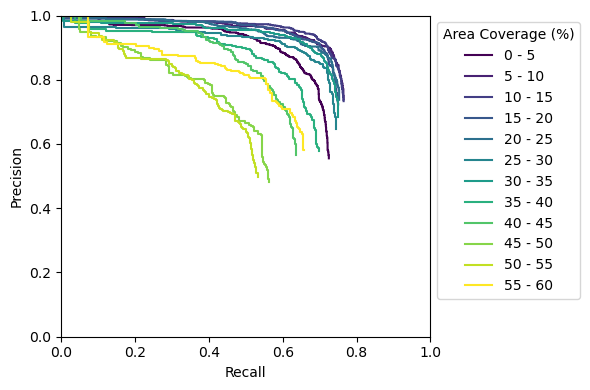

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Specify the directory containing the CSV files
directory = '/home/rohit/AIXI/solid_frac/8_11_curve_data'

# Desired labels
labels = ['0 - 5', '5 - 10', '10 - 15', '15 - 20', '20 - 25', '25 - 30', '30 - 35', '35 - 40', '40 - 45', '45 - 50', '50 - 55', '55 - 60']

# Initialize lists to store data for plotting
precision_recall_data = []
interpolated_precision_recall_data = []

# Collect all CSV files and sort them based on the solid fraction range
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]
csv_files_sorted = sorted(csv_files, key=lambda x: int(x.split('_')[0]))  # Sort by the first number before '_'

# Color map
color_map = plt.cm.get_cmap('viridis', len(csv_files_sorted))  # Get a color map from matplotlib

# Loop through sorted files to maintain order in the legend
for idx, filename in enumerate(csv_files_sorted):
    file_path = os.path.join(directory, filename)
    
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Use the corresponding label from the labels list
    label = labels[idx]
    
    # Append data for plotting with associated color index
    precision_recall_data.append((df['Recall'], df['Precision'], label, color_map(idx)))
    interpolated_precision_recall_data.append((df['Interpolated Recall'], df['Interpolated Precision'], label, color_map(idx)))

'''
# Plotting Precision vs Recall for all solid fractions
plt.figure(figsize=(10, 10))
for recall, precision, label, color in precision_recall_data:
    plt.plot(recall, precision, label=label, color=color)
plt.title('Precision vs Recall for Different Solid Fractions')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0, 1)  # Set x-axis limits
plt.ylim(0, 1)  # Set y-axis limits
plt.legend(title='Solid Fraction', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()
'''

# Plotting Interpolated Precision vs Interpolated Recall for all solid fractions
plt.figure(figsize=(6, 4))
for interpolated_recall, interpolated_precision, label, color in interpolated_precision_recall_data:
    plt.plot(interpolated_recall, interpolated_precision, label=label, color=color)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0, 1)  # Set x-axis limits
plt.ylim(0, 1)  # Set y-axis limits
plt.legend(title='Area Coverage (%)', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(False)
plt.tight_layout()
plt.show()


   Solid Fraction        AP      AP50      AP75   APsmall  APmedium   APlarge  \
0            0-5%  0.323360  0.666416  0.285894  0.153945  0.391079  0.594666   
1           5-10%  0.411070  0.727337  0.424839  0.157285  0.461837  0.512392   
2          10-15%  0.427189  0.737727  0.429279  0.108866  0.476903  0.452264   
3          15-20%  0.384097  0.717396  0.364196  0.064631  0.445382  0.356091   
4          20-25%  0.400854  0.694921  0.403247  0.040941  0.439314  0.377337   
5          25-30%  0.325941  0.658576  0.284336  0.048413  0.316128  0.378440   
6          30-35%  0.337058  0.652310  0.305260  0.017822  0.332131  0.384809   
7          35-40%  0.279937  0.600863  0.206004  0.039604  0.251217  0.325234   
8          40-45%  0.217022  0.569755  0.091085  0.023515  0.154121  0.265007   
9          50-55%  0.169116  0.444732  0.105970  0.016832  0.114732  0.198919   
10         55-60%  0.221629  0.562649  0.135585  0.000000  0.140728  0.251815   

         AR1      AR10     

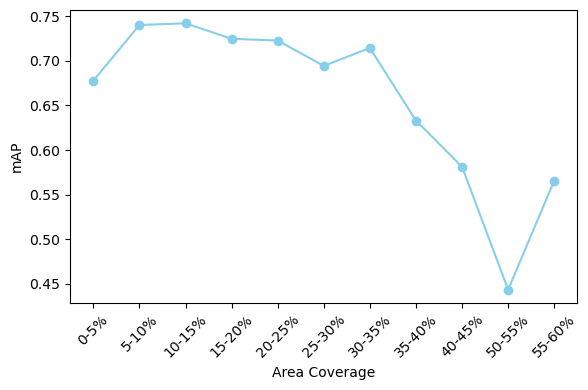

In [2]:
import pandas as pd
import re

# Specify the path to the text file containing the metrics
file_path = 'metrics.txt'

# Read the entire content of the file
with open(file_path, 'r') as file:
    data = file.read()

# Define a regex pattern to capture each section based on solid fraction groups
pattern = r'(\d+-\d+%)'  # Capture groups like '0-5%', '5-10%', etc.
sections = re.split(pattern, data)[1:]  # Split and ignore the first empty result

# Initialize an empty DataFrame
df = pd.DataFrame()

# Loop through sorted files to maintain order in the legend
for i in range(0, len(sections), 2):
    solid_frac = sections[i].strip()
    metrics_text = sections[i+1]

    # Extract values using regex
    metrics = {
        'Solid Fraction': solid_frac,
        'AP': float(re.search(r'AP: ([\d.]+)', metrics_text).group(1)),
        'AP50': float(re.search(r'AP50: ([\d.]+)', metrics_text).group(1)),
        'AP75': float(re.search(r'AP75: ([\d.]+)', metrics_text).group(1)),
        'APsmall': float(re.search(r'APsmall: ([\d.]+)', metrics_text).group(1)),
        'APmedium': float(re.search(r'APmedium: ([\d.]+)', metrics_text).group(1)),
        'APlarge': float(re.search(r'APlarge: ([\d.]+)', metrics_text).group(1)),
        'AR1': float(re.search(r'AR1: ([\d.]+)', metrics_text).group(1)),
        'AR10': float(re.search(r'AR10: ([\d.]+)', metrics_text).group(1)),
        'AR100': float(re.search(r'AR100: ([\d.]+)', metrics_text).group(1)),
        'ARsmall': float(re.search(r'ARsmall: ([\d.]+)', metrics_text).group(1)),
        'ARmedium': float(re.search(r'ARmedium: ([\d.]+)', metrics_text).group(1)),
        'ARlarge': float(re.search(r'ARlarge: ([\d.]+)', metrics_text).group(1)),
        'Pascal AP': float(re.search(r'grain: ([\d.]+)', metrics_text).group(1)),
        'mAP': float(re.search(r'mAP: ([\d.]+)', metrics_text).group(1))
    }

    # Create a DataFrame from the metrics dictionary
    metrics_df = pd.DataFrame([metrics])

    # Concatenate the new DataFrame with the existing DataFrame
    df = pd.concat([df, metrics_df], ignore_index=True)

# Display the DataFrame
print(df)

# Ensure the solid fraction is treated as a categorical variable and sort by it
df['Solid Fraction'] = pd.Categorical(df['Solid Fraction'], categories=[f"{i}-{i+5}%" for i in range(0, 100, 5)], ordered=True)
df.sort_values('Solid Fraction', inplace=True)

# Plotting mAP vs Solid Fraction
plt.figure(figsize=(6, 4))
plt.plot(df['Solid Fraction'], df['mAP'], marker='o', linestyle='-', color='skyblue')
#plt.title('mAP vs Area Coverage')
plt.xlabel('Area Coverage')
plt.ylabel('mAP')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(False)
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()



In [18]:
plt.figure(figsize=(10, 6))
plt.plot(df['Solid Fraction'], df['AR100'], marker='o', linestyle='-', color='skyblue')
plt.title('Recall vs Solid Fraction')
plt.xlabel('Solid Fraction')
plt.grid(True)
plt.ylabel('AR100 (100 detections per image)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()


KeyError: 'Solid Fraction'

<Figure size 1000x600 with 0 Axes>

count    326.000000
mean       0.170587
std        0.178825
min        0.000825
25%        0.018645
50%        0.108872
75%        0.277442
max        0.675455
Name: solid_fraction, dtype: float64
Skewness: 1.011204
Kurtosis: 0.003960


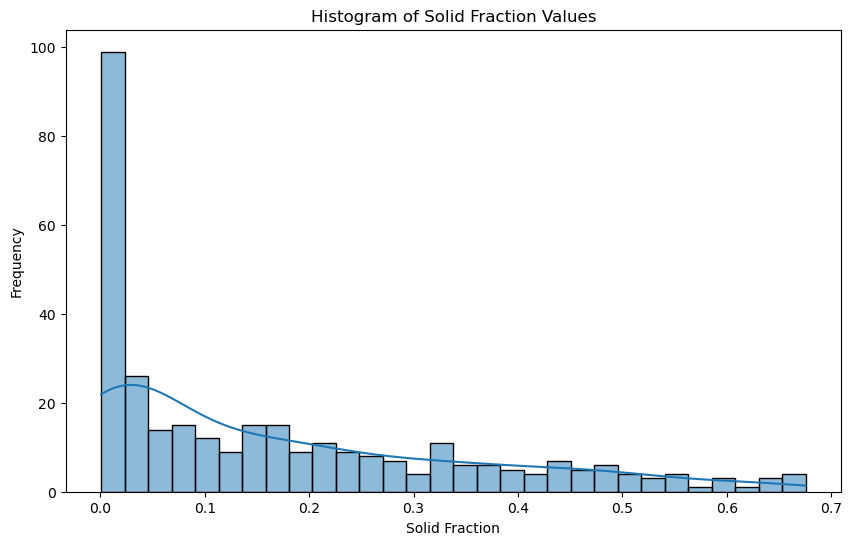

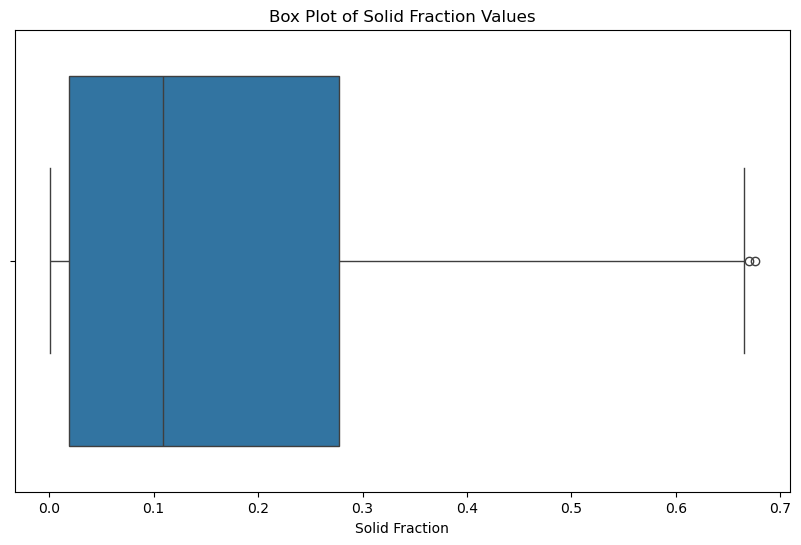

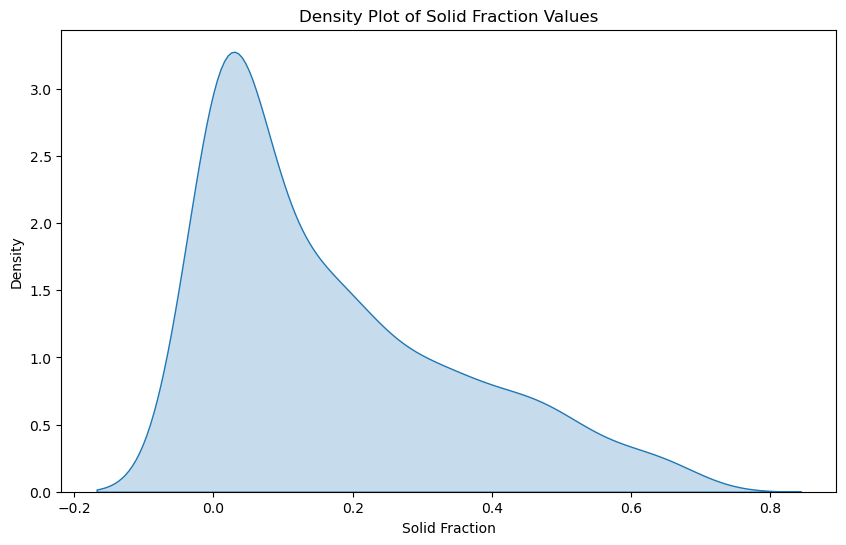

Shapiro-Wilk Test: Statistics=0.853, p=0.000


In [3]:
# temp / can remove - statistical checks on solid fraction distribution

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, shapiro

# Load your data
df = pd.read_csv('solid_fractions.csv')

# Descriptive statistics
print(df['solid_fraction'].describe())

# Skewness and Kurtosis
print("Skewness: %f" % df['solid_fraction'].skew())
print("Kurtosis: %f" % df['solid_fraction'].kurt())

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['solid_fraction'], kde=True, bins=30)
plt.title('Histogram of Solid Fraction Values')
plt.xlabel('Solid Fraction')
plt.ylabel('Frequency')
plt.show()

# Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['solid_fraction'])
plt.title('Box Plot of Solid Fraction Values')
plt.xlabel('Solid Fraction')
plt.show()

# Density Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(df['solid_fraction'], fill=True)
plt.title('Density Plot of Solid Fraction Values')
plt.xlabel('Solid Fraction')
plt.show()

# Normality Test
stat, p = shapiro(df['solid_fraction'])
print('Shapiro-Wilk Test: Statistics=%.3f, p=%.3f' % (stat, p))

